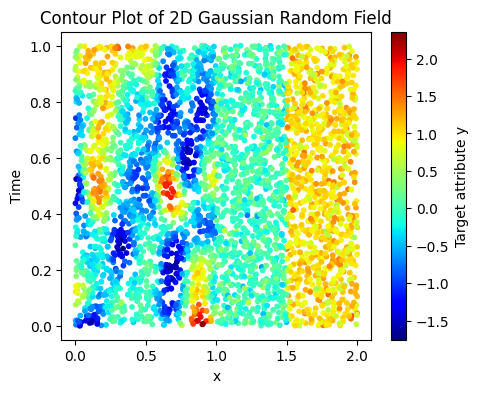

In [4]:
from time import gmtime, strftime
from tqdm import tqdm

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
import IPython
# %matplotlib qt
import seaborn as sns

# import stream_generator
import learning_models
from datasets.data_loader import load_dataset

from dth import DTH
import neural_net_base_learner
# import wandb
import os
from utility.utilities import Logger, Plotter
from utility.sample import Sample


def generate_2d_gaussian_random_field(num_points, scale):
    # Sample x and y randomly
    x = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Compute the distance matrix
    d = np.sqrt((x[:, None] - x[None, :])**2 + (t[:, None] - t[None, :])**2)
    
    # Define the covariance function
    covariance_func = np.exp(-d**2 / (2 * scale**2))
    
    # Generate the random field
    mean = np.zeros(num_points)
    y = np.random.multivariate_normal(mean, covariance_func)
    y = y + np.random.normal(0, .1, num_points)
    return x, t, y

def generate_2_class_field(num_points):
    # Sample x and y randomly
    x = np.random.uniform(1, 2, num_points)
    t = np.random.uniform(0, 1, num_points)
    
    # Generate the random field
    y = np.zeros(num_points)
    for i in range(num_points):
        if x[i] > 1.5:
        # if x[i]+t[i] > 1:
            y[i] = 1
    y = y + np.random.normal(0, .2, num_points)
    return x, t, y



# Parameters
num_points = 2000  # Number of points to sample
scale = 0.1  # Scale of the correlation

# Generate field
x1, t1, y1 = generate_2d_gaussian_random_field(num_points, scale)
x2, t2, y2 = generate_2_class_field(int(num_points/1))

# combine the data into one dataset
x = np.concatenate((x1, x2))
t = np.concatenate((t1, t2))
y = np.concatenate((y1, y2))

num_samples = len(x)
# Make a stream of samples
stream = []
for i in range(num_samples):
    stream.append((x[i], y[i], t[i], None))
# sort samples in the stream by time
stream.sort(key=lambda sample: sample[2])

%matplotlib inline
# Create a contour plot
plt.figure(figsize=(5, 4))
# plt.tricontourf(x, t, y, levels=20, cmap='viridis')
# plt.colorbar(label='Target attribute y')
vmin = min(y)
vmax = max(y)
plt.scatter(x, t, c=y, s=10, cmap='jet',vmin=vmin, vmax=vmax)
plt.colorbar(label='Target attribute y')
plt.title('Contour Plot of 2D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('Time')
plt.show()


In [5]:
%matplotlib qt


dth = DTH(epsilon=5,
           num_sub_learners=10,
             min_new_samples_for_base_learner_update=10,
               min_new_samples_for_pruining=5,
               multi_threading_sub_learners=True,
               pruning_disabled=False,
               num_pruning_threads=1,
               max_elimination=10)
y_pred = []
stream = np.array(stream)
samples_in_memory = []
for i, (X, y, t, y_pred) in enumerate(tqdm(stream)):
    stream[i,3] = dth.predict_online_model([X], t)
    dth.add_sample([X], y, t)
    dth.update_online_model()
    samples_in_memory.append(len(dth.memory))


    memory_X = [sample[0] for sample in dth.memory]
    memory_t = [sample[2] for sample in dth.memory]
    memory_y = [sample[1] for sample in dth.memory]

    plt.cla()
    # draw hline at t
    plt.axhline(t, color='r', linestyle='--', lw=1)
    plt.scatter(memory_X, memory_t, c=memory_y, s=10, cmap='jet',vmax=vmax, vmin=vmin)
    plt.xlim(0, 2)
    plt.ylim(0, 1)
    plt.pause(0.0000001)


    

    

100%|██████████| 4000/4000 [1:11:06<00:00,  1.07s/it]    


(1000, 4)


In [28]:
# set back theme to dark
sns.set_theme(style="darkgrid")


plt.subplot(1, 2, 1)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,1], s=10, cmap='jet')
plt.title('Actual values')
plt.xlabel('x')
plt.ylabel('Time')

plt.subplot(1, 2, 2)
plt.scatter(stream[:,0], stream[:,2], c=stream[:,3], s=10, cmap='jet')
plt.title('Predicted values')
plt.xlabel('x')
plt.ylabel('Time')
plt.tight_layout()
plt.show()

In [6]:
plt.plot(samples_in_memory)